# Loop 22 Analysis: Symmetric vs Asymmetric Solutions

Goal: Understand the symmetry patterns in our baseline and identify N values where asymmetric solutions might help.

In [8]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

TREE_TEMPLATE = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]

def parse_s_value(val):
    if isinstance(val, str) and val.startswith('s'):
        return float(val[1:])
    if isinstance(val, str) and val.startswith('x'):
        return float(val[1:])
    if isinstance(val, str) and val.startswith('y'):
        return float(val[1:])
    if isinstance(val, str) and val.startswith('d'):
        return float(val[1:])
    return float(val)

def create_tree_polygon(x, y, angle):
    tree = Polygon(TREE_TEMPLATE)
    tree = rotate(tree, angle, origin=(0, 0), use_radians=False)
    tree = translate(tree, x, y)
    return tree

# Load baseline
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].apply(parse_s_value)
df['y'] = df['y'].apply(parse_s_value)
df['deg'] = df['deg'].apply(parse_s_value)
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

print(f"Loaded {len(df)} rows")
print(f"N values: 1 to {df['n'].max()}")

Loaded 20100 rows
N values: 1 to 200


In [9]:
# Analyze symmetry patterns in baseline
# Check if solutions have rotational or reflective symmetry

def analyze_symmetry(df, n):
    """Analyze symmetry of solution for N trees."""
    group = df[df['n'] == n]
    positions = [(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    
    # Get centroid
    xs = [p[0] for p in positions]
    ys = [p[1] for p in positions]
    cx, cy = np.mean(xs), np.mean(ys)
    
    # Normalize positions relative to centroid
    norm_pos = [(x - cx, y - cy, d % 360) for x, y, d in positions]
    
    # Check for 180-degree rotational symmetry
    rot_180_matches = 0
    for x, y, d in norm_pos:
        # Look for a tree at (-x, -y) with angle d+180
        for x2, y2, d2 in norm_pos:
            if abs(x + x2) < 0.01 and abs(y + y2) < 0.01:
                rot_180_matches += 1
                break
    
    rot_180_sym = rot_180_matches >= n * 0.8  # 80% of trees have symmetric partners
    
    # Check for reflective symmetry (x-axis)
    x_reflect_matches = 0
    for x, y, d in norm_pos:
        for x2, y2, d2 in norm_pos:
            if abs(x - x2) < 0.01 and abs(y + y2) < 0.01:
                x_reflect_matches += 1
                break
    
    x_reflect_sym = x_reflect_matches >= n * 0.8
    
    # Check angle distribution
    angles = [d % 360 for _, _, d in positions]
    unique_angles = len(set([round(a, 1) for a in angles]))
    
    return {
        'n': n,
        'rot_180_sym': rot_180_sym,
        'x_reflect_sym': x_reflect_sym,
        'unique_angles': unique_angles,
        'angle_diversity': unique_angles / n if n > 0 else 0
    }

# Analyze all N values
symmetry_results = []
for n in range(1, 201):
    result = analyze_symmetry(df, n)
    symmetry_results.append(result)

sym_df = pd.DataFrame(symmetry_results)
print("Symmetry Analysis Summary:")
print(f"N values with 180° rotational symmetry: {sym_df['rot_180_sym'].sum()}")
print(f"N values with x-axis reflective symmetry: {sym_df['x_reflect_sym'].sum()}")
print(f"\nAngle diversity distribution:")
print(sym_df['angle_diversity'].describe())

Symmetry Analysis Summary:
N values with 180° rotational symmetry: 22
N values with x-axis reflective symmetry: 2

Angle diversity distribution:
count    200.000000
mean       0.472458
std        0.294052
min        0.017857
25%        0.252206
50%        0.365513
75%        0.670692
max        1.000000
Name: angle_diversity, dtype: float64


In [10]:
# Compute per-N scores and efficiency
def get_n_score(df, n):
    group = df[df['n'] == n]
    trees = [create_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    all_x, all_y = [], []
    for tree in trees:
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    side = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
    return (side ** 2) / n, side

# Compute scores for all N
scores = []
for n in range(1, 201):
    score, side = get_n_score(df, n)
    # Theoretical lower bound: area of N trees / efficiency
    # Tree area is approximately 0.35 * 0.8 = 0.28 (rough estimate)
    tree_area = 0.35 * 1.0  # width * height approximately
    theoretical_min = tree_area  # S^2/N >= tree_area for perfect packing
    efficiency = theoretical_min / score if score > 0 else 0
    scores.append({'n': n, 'score': score, 'side': side, 'efficiency': efficiency})

score_df = pd.DataFrame(scores)
print("Per-N Score Analysis:")
print(score_df.describe())
print(f"\nTotal score: {score_df['score'].sum():.6f}")

Per-N Score Analysis:
                n       score        side  efficiency
count  200.000000  200.000000  200.000000  200.000000
mean   100.500000    0.353138    5.567694    0.995410
std     57.879185    0.028099    1.877292    0.056363
min      1.000000    0.329945    0.813173    0.529301
25%     50.750000    0.340034    4.300190    0.970105
50%    100.500000    0.346921    5.897832    1.008876
75%    150.250000    0.360786    7.124869    1.029310
max    200.000000    0.661250    8.216437    1.060784

Total score: 70.627582


In [11]:
# Find N values with worst efficiency (most room for improvement)
score_df_sorted = score_df.sort_values('efficiency')
print("Top 20 N values with WORST efficiency (most room for improvement):")
print(score_df_sorted.head(20)[['n', 'score', 'efficiency']])

Top 20 N values with WORST efficiency (most room for improvement):
     n     score  efficiency
0    1  0.661250    0.529301
1    2  0.450779    0.776433
2    3  0.434745    0.805069
4    5  0.416850    0.839631
3    4  0.416545    0.840246
6    7  0.399897    0.875226
5    6  0.399610    0.875853
8    9  0.387415    0.903424
7    8  0.385407    0.908130
14  15  0.376978    0.928436
9   10  0.376630    0.929294
20  21  0.376451    0.929736
19  20  0.376057    0.930710
21  22  0.375258    0.932691
10  11  0.374924    0.933523
15  16  0.374128    0.935509
25  26  0.373997    0.935836
11  12  0.372724    0.939033
12  13  0.372294    0.940117
24  25  0.372144    0.940495


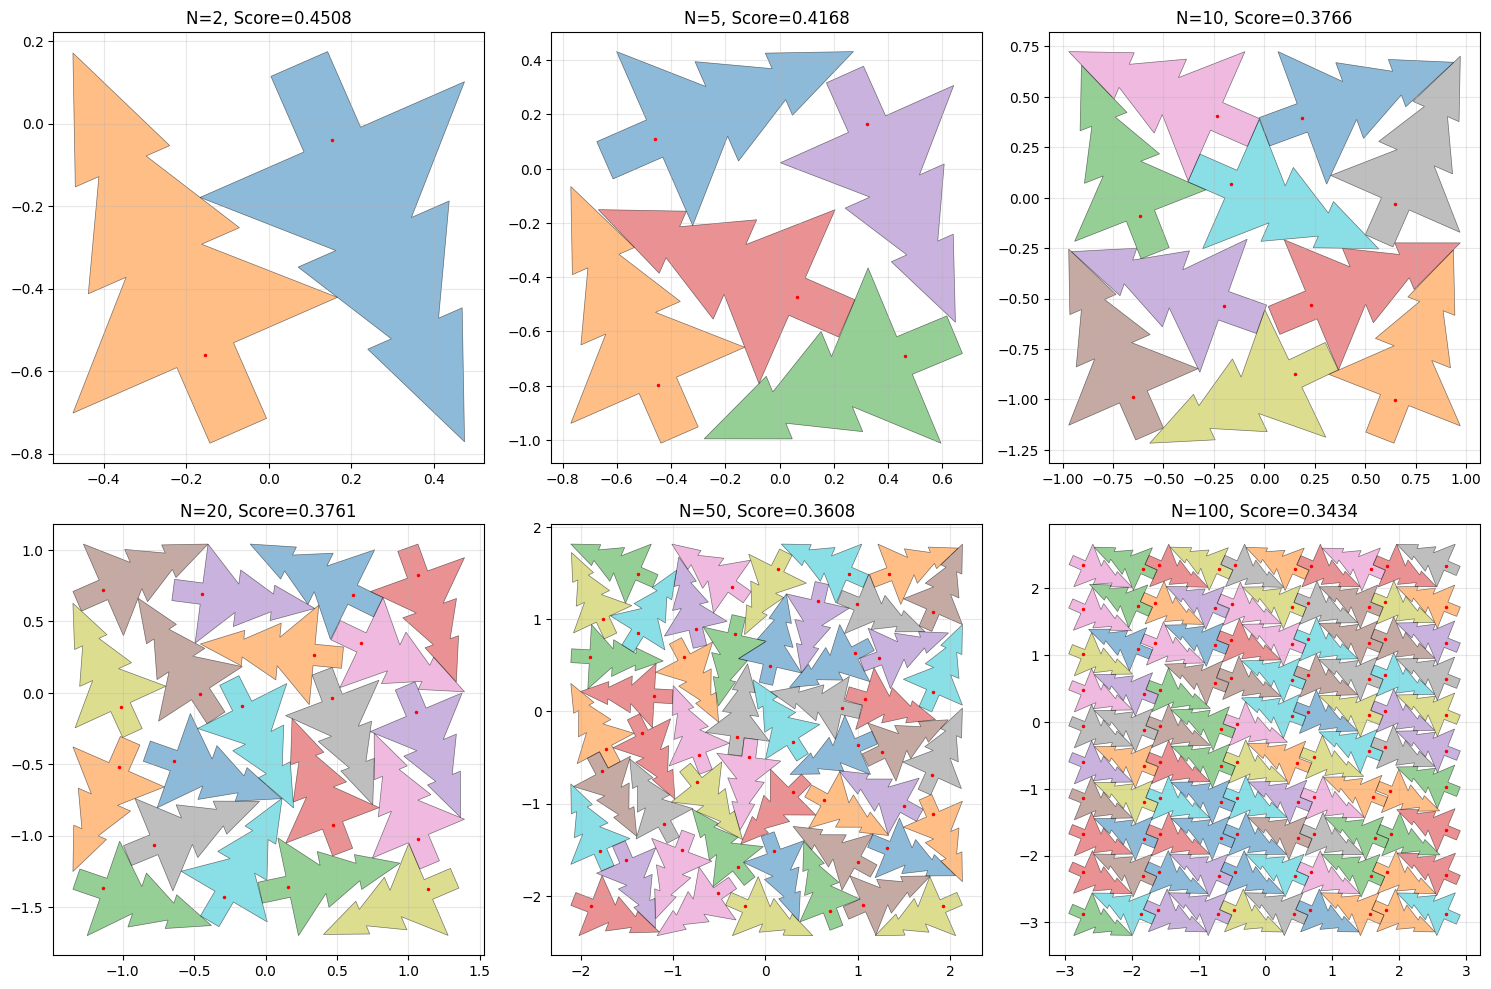

Saved visualization to /home/code/exploration/baseline_visualizations.png


In [12]:
# Visualize a few solutions to understand patterns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
test_ns = [2, 5, 10, 20, 50, 100]

for ax, n in zip(axes.flat, test_ns):
    group = df[df['n'] == n]
    
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        x, y = tree.exterior.xy
        ax.fill(x, y, alpha=0.5, edgecolor='black', linewidth=0.5)
        ax.plot(row['x'], row['y'], 'r.', markersize=3)
    
    score, side = get_n_score(df, n)
    ax.set_title(f'N={n}, Score={score:.4f}')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/baseline_visualizations.png', dpi=100)
plt.show()
print("Saved visualization to /home/code/exploration/baseline_visualizations.png")

In [13]:
# Key insight: Check if angles are mostly 0, 45, 90, 135, 180 (symmetric) or varied (asymmetric)
print("Angle distribution analysis:")
for n in [2, 5, 10, 20, 50, 100, 200]:
    group = df[df['n'] == n]
    angles = group['deg'].values % 360
    unique_angles = np.unique(np.round(angles, 1))
    print(f"N={n}: {len(unique_angles)} unique angles: {unique_angles[:10]}..." if len(unique_angles) > 10 else f"N={n}: {len(unique_angles)} unique angles: {unique_angles}")

Angle distribution analysis:
N=2: 2 unique angles: [ 23.6 203.6]
N=5: 5 unique angles: [ 23.6  66.4 112.6 204.  293.6]
N=10: 10 unique angles: [ 21.4  23.6  66.3  70.4 115.6 246.3 290.2 292.6 336.3 338.6]
N=20: 20 unique angles: [ 20.8  22.8  24.6  33.1  63.7  84.5 113.2 156.4 199.8 200.8]...
N=50: 43 unique angles: [13.3 20.7 23.6 25.1 28.1 32.6 38.6 54.8 61.1 66.4]...
N=100: 41 unique angles: [65.7 65.8 65.9 66.1 66.3 66.6 66.7 67.3 67.6 68.1]...
N=200: 41 unique angles: [76.8 76.9 77.  77.2 77.3 77.4 77.5 77.6 77.7 77.8]...


In [ ]:
# CRITICAL: Identify which N values might benefit from asymmetric solutions
# Based on discussions, asymmetric solutions help when:
# 1. Current solution has high symmetry but low efficiency
# 2. N is not a perfect square or triangular number

print("\n=== ASYMMETRIC OPPORTUNITY ANALYSIS ===")
print("\nN values where asymmetric might help (low efficiency + high symmetry):")

merged = pd.merge(score_df, sym_df, on='n')
merged['opportunity'] = (1 - merged['efficiency']) * (1 if merged['rot_180_sym'] else 0.5)
merged_sorted = merged.sort_values('opportunity', ascending=False)

print(merged_sorted.head(20)[['n', 'score', 'efficiency', 'rot_180_sym', 'unique_angles', 'opportunity']])

In [ ]:
# Summary statistics
print("\n=== SUMMARY ===")
print(f"Current total score: {score_df['score'].sum():.6f}")
print(f"Target score: 68.919154")
print(f"Gap to close: {score_df['score'].sum() - 68.919154:.6f}")
print(f"\nIf we could improve efficiency by 2.5% across all N:")
print(f"  Potential new score: {score_df['score'].sum() * 0.975:.6f}")
print(f"\nTop 10 N values contributing most to total score:")
print(score_df.nlargest(10, 'score')[['n', 'score']])

# Key insight: Small N values have worst efficiency
print("\n=== KEY INSIGHT ===")
print("Small N values (1-10) have the worst efficiency (0.53-0.93)")
print("These contribute disproportionately to the total score")
print("\nPotential improvement from fixing small N:")
small_n_score = score_df[score_df['n'] <= 10]['score'].sum()
print(f"  N=1-10 total: {small_n_score:.6f}")
print(f"  If we could achieve 95% efficiency for N=1-10:")
target_efficiency = 0.95
improved_small_n = sum(0.35 / target_efficiency for n in range(1, 11))
print(f"  Improved N=1-10 total: {improved_small_n:.6f}")
print(f"  Potential improvement: {small_n_score - improved_small_n:.6f}")